# Transfer Learning with Tensorflow part 2 : Fine tuning

In [2]:
# Check if we're using a GPU
!nvidia-smi

Wed Jan 25 12:44:08 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    27W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!wget https://raw.githubusercontent.com/maulairfani/DataScience-Learning-Notebooks/main/helper_functions.py

--2023-01-25 12:44:08--  https://raw.githubusercontent.com/maulairfani/DataScience-Learning-Notebooks/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-01-25 12:44:09 (84.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
# Import helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Let's get some data

link : https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [5]:
# Get 10% of training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2023-01-25 12:44:13--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.128, 172.217.194.128, 74.125.68.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  24.4MB/s    in 7.8s    

2023-01-25 12:44:22 (20.5 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [6]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

In [7]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [8]:
import tensorflow as tf
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical",
                                                                           batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [9]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [10]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [11]:
for images, labels in train_data_10_percent.take(1):
    print(images, labels)

tf.Tensor(
[[[[1.43198990e+02 1.03198982e+02 5.29132652e+01]
   [1.52214279e+02 1.07000000e+02 6.51938782e+01]
   [1.56571426e+02 1.07000000e+02 7.10816345e+01]
   ...
   [7.21940804e+00 1.61576523e+02 1.65790817e+02]
   [8.14283943e+00 1.60142838e+02 1.65142838e+02]
   [1.05969391e+01 1.57596939e+02 1.65596939e+02]]

  [[1.45357147e+02 1.05357147e+02 5.50714264e+01]
   [1.53938782e+02 1.09852043e+02 6.51428604e+01]
   [1.56372452e+02 1.07397964e+02 6.96683655e+01]
   ...
   [7.52553511e+00 1.62612228e+02 1.62637772e+02]
   [1.06428757e+01 1.62642883e+02 1.65642883e+02]
   [1.81173382e+01 1.66045914e+02 1.70260193e+02]]

  [[1.46923477e+02 1.05933670e+02 5.74285698e+01]
   [1.54142853e+02 1.09928574e+02 6.51428604e+01]
   [1.57571426e+02 1.09000000e+02 6.85714264e+01]
   ...
   [6.40822887e+00 1.61933716e+02 1.57811279e+02]
   [1.51429090e+01 1.68142914e+02 1.65928619e+02]
   [1.37142944e+01 1.62704102e+02 1.61994904e+02]]

  ...

  [[1.28321457e+02 1.22250008e+02 9.43213959e+01]
   [1

## Model 0: Building a transfer learning feature extraction model using the Keras Functional API

it gives us more flexibel with our models

In [12]:
# 1. Create the base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the basee model
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2 you will need to normalize inputs
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base model
x = base_model(inputs)
print(f"Shape after passing inputs through base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the modt important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine th einputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model
history_model_0 = model_0.fit(train_data_10_percent,
                              epochs=5,
                              steps_per_epoch=len(train_data_10_percent),
                              validation_data=test_data_10_percent,
                              validation_steps=int(len(test_data_10_percent)*.25),
                              callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                     experiment_name="10_percent_feature_extraction")])

16705208/16705208 [==============================] - 2s 0us/step
Shape after passing inputs through base_model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20230125-124435
Epoch 1/5
24/24 [==============================] - 20s 290ms/step - loss: 1.8826 - accuracy: 0.4520 - val_loss: 1.3057 - val_accuracy: 0.7599
Epoch 2/5
24/24 [==============================] - 5s 192ms/step - loss: 1.0899 - accuracy: 0.7853 - val_loss: 0.8892 - val_accuracy: 0.8306
Epoch 3/5
24/24 [==============================] - 5s 198ms/step - loss: 0.7807 - accuracy: 0.8320 - val_loss: 0.7005 - val_accuracy: 0.8569
Epoch 4/5
24/24 [==============================] - 5s 202ms/step - loss: 0.6366 - accuracy: 0.8600 - val_loss: 0.6328 - val_accuracy: 0.8651
Epoch 5/5
24/24 [==============================] - 5s 182ms/step - loss: 0.5361 - accuracy: 0.8747 - val_loss: 0.5599 - val_accuracy: 0.8635


In [13]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 tf.math.truediv
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activati

In [14]:
# How about we get a summary of the base model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [15]:
# How about a summary of our whole model
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


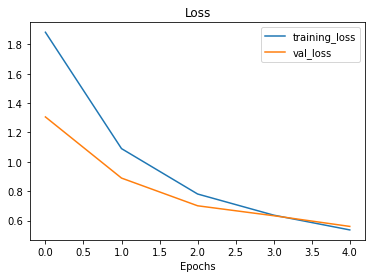

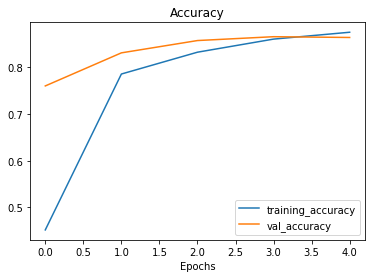

In [16]:
# Check out our model's training curves
plot_loss_curves(history_model_0)

## Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D Layer...

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280)

But then when it passes through GlobalAveragePooling2D layer, it turns into (None, 1280)

Let's use a similar shaped tensor of (1, 4, 4, 3)

In [17]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooled 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shape of 2 different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor: (1, 3)


In [18]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

## Running a series of transfer learning experiments

we'll go with 1% data instead of 10%

1. `model_1` - use feature extraction transfer learning with 1% of training data with data augmentation
2. `model_2` - use feature extraction with 10% of training with data augmentation
3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation
4. `model_4` -  use fine-tuning transfer learning on 100% of the training data with data augmentation

### Getting and preprocessing data for model_1

In [19]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

unzip_data("10_food_classes_1_percent.zip")

--2023-01-25 12:45:24--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 74.125.24.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  23.9MB/s    in 6.3s    

2023-01-25 12:45:30 (20.3 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [20]:
# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test"

# How many images are we working with
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There a

In [21]:
# Setup data loaders
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           batch_size=32,
                                                                           image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=32)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

* `tf.keras.layers.experimental.preprocessing()`

the benefits of using data augmentation inside the model are:
* Preprocessing of images (augmenting them) happends on the GPU
* Image data augmentation only happens during training, so we can still export our whole model an duse it elsewhere (bisa sekalian di save)

In [22]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotations, zooms, etc
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.Rescale(1./255) 
], name="data_augmentation")

 ### Visualize our data augmentation layer (and see what happens to our data)

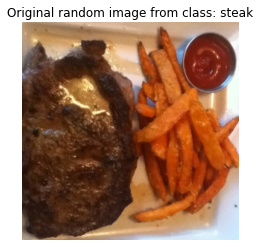

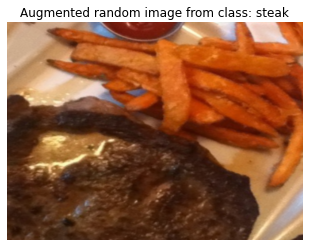

In [61]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read and plot in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False);

# Now let's plot our augmented random image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0), training=True)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [68]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Adding data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(.25 * len(test_data)),
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                       experiment_name="1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20230125-131943
Epoch 1/5


3/3 [==============================] - ETA: 0s - loss: 2.3281 - accuracy: 0.1714

3/3 [==============================] - 10s 2s/step - loss: 2.3281 - accuracy: 0.1714 - val_loss: 2.1947 - val_accuracy: 0.2007
Epoch 2/5
3/3 [==============================] - 3s 1s/step - loss: 2.1436 - accuracy: 0.2143 - val_loss: 2.0809 - val_accuracy: 0.2549
Epoch 3/5
3/3 [==============================] - 3s 1s/step - loss: 1.8608 - accuracy: 0.5286 - val_loss: 1.9749 - val_accuracy: 0.3174
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 1.7502 - accuracy: 0.5714 - val_loss: 1.8654 - val_accuracy: 0.3849
Epoch 5/5
3/3 [==============================] - 4s 2s/step - loss: 1.5548 - accuracy: 0.6571 - val_loss: 1.7684 - val_accuracy: 0.4441


In [69]:
# Check out a model summary
model_1.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, 3)          0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [70]:
# Evaluate on the fill test dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 7s 78ms/step - loss: 1.7906 - accuracy: 0.4448


[1.7905662059783936, 0.4447999894618988]

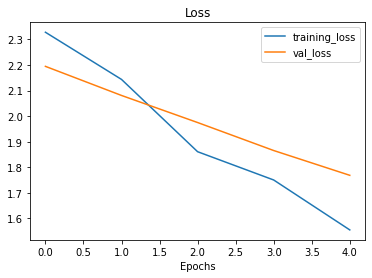

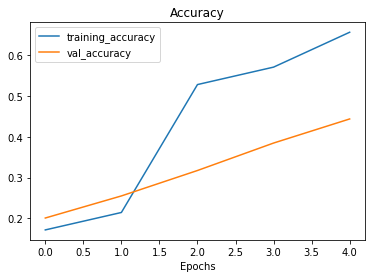

In [71]:
plot_loss_curves(history_1_percent)

## Model 2: Feature Extraction Transfer Learning on 10% of data with data augmenatation

In [74]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Adding data augmentation Sequential model as a layer
x = data_augmentation(inputs, training=False)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax")(x)

# Make a model using the inputs and outputs
model_2 = keras.Model(inputs, outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_model_2 = model_2.fit(train_data_10_percent,
                              epochs=5,
                              steps_per_epoch=len(train_data_10_percent),
                              validation_data=test_data,
                              validation_steps=int(0.25 * len(test_data)),
                              callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                     experiment_name="10_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20230125-133350
Epoch 1/5


23/24 [===========================>..] - ETA: 0s - loss: 1.9318 - accuracy: 0.3804

24/24 [==============================] - 10s 203ms/step - loss: 1.9205 - accuracy: 0.3907 - val_loss: 1.3156 - val_accuracy: 0.7286
Epoch 2/5
24/24 [==============================] - 4s 148ms/step - loss: 1.0798 - accuracy: 0.7640 - val_loss: 0.8794 - val_accuracy: 0.7977
Epoch 3/5
24/24 [==============================] - 4s 146ms/step - loss: 0.7580 - accuracy: 0.8347 - val_loss: 0.6973 - val_accuracy: 0.8240
Epoch 4/5
24/24 [==============================] - 4s 147ms/step - loss: 0.6088 - accuracy: 0.8680 - val_loss: 0.6083 - val_accuracy: 0.8503
Epoch 5/5
24/24 [==============================] - 5s 183ms/step - loss: 0.5141 - accuracy: 0.8853 - val_loss: 0.5550 - val_accuracy: 0.8569


In [77]:
# Evaluate on the fill test dataset
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 7s 80ms/step - loss: 0.5535 - accuracy: 0.8604


[0.5535013675689697, 0.8604000210762024]

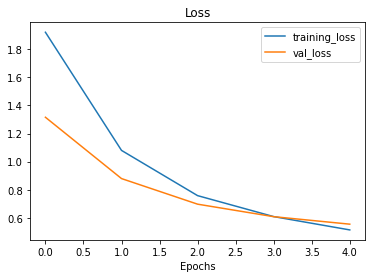

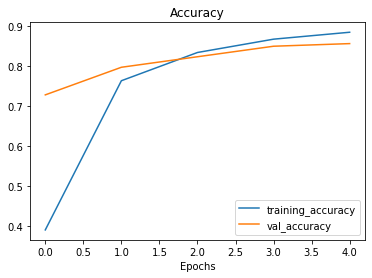

In [78]:
plot_loss_curves(history_model_2)

In [79]:
model_2.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, 3)          0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 dense_1 (Dense)             (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina